In [1]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os

import seaborn as sns
sns.set_theme(style="white", font_scale=1.1, rc={'xtick.bottom': True, 'ytick.left': True})

# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)


In [2]:
def get_solutions_all_folds_rollOCT(name_dataset: str, depth=8, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

def get_solutions_all_folds_cart(name_dataset: str, depth=8, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

# get mcc list (one entry per fold) for specific depth 
def get_acc_list(dataset_name, max_tree_depth, depth, folds_available, cart = False):
    if cart == False:
        sol_dict = get_solutions_all_folds_rollOCT(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    else:
        sol_dict = get_solutions_all_folds_cart(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)

    acc_scores_test = []
    acc_scores_train = []

    for fold in range(1, folds_available+1):
        
        y_true_test = sol_dict[fold][depth]['test']['y']
        y_predict_test = sol_dict[fold][depth]['test']['prediction']

        y_true_train = sol_dict[fold][depth]['train']['y']
        y_predict_train = sol_dict[fold][depth]['train']['prediction']
        
        acc_test = accuracy_score(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        acc_train = accuracy_score(y_true_train, y_predict_train)

        acc_scores_test.append(acc_test)
        acc_scores_train.append(acc_train)
    
    return acc_scores_test, acc_scores_train

def acc_dict_all_data(list_names, max_tree_depth, depth, folds, cart = False):
    acc_dict = dict() #entry contains list with #folds values
    for i, name in enumerate(list_names):
        acc_dict[name] = dict()
        acc_scores_test, acc_scores_train = get_acc_list(dataset_name = name, max_tree_depth = max_tree_depth, depth = depth, folds_available = folds, cart = cart)
        acc_dict[name]['test'] = acc_scores_test
        acc_dict[name]['train'] = acc_scores_train
    return acc_dict

def get_solutions_all_folds_refact_tree(name_dataset: str, depth=8, folds_available = 10) -> dict: #depth is the depth used for the forests
    sol_dict = {} # one entry for every fold, [fold] for classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        sol_dict[i] = pd.read_csv(f"../results/{name_dataset}_refactored_tree_pulp/fold{i}/{name_dataset}_result_test.csv")
    return sol_dict

def get_acc_list_refact_tree(dataset_name, depth_of_tree, folds_available):
    sol_dict = get_solutions_all_folds_refact_tree(name_dataset = dataset_name, depth=depth_of_tree, folds_available = folds_available)
    
    acc_scores = []

    for fold in range(1, folds_available+1):
        
        y_true_test = sol_dict[fold]['y']
        y_predict_test = sol_dict[fold]['prediction']

        
        acc_test = accuracy_score(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes

        acc_scores.append(acc_test)
    
    return acc_scores

In [3]:
def acc_dict_all_data(list_names, depth, folds_tree):
    acc_dict = dict() #entry contains list with #folds values
    for i, name in enumerate(list_names):
        acc_dict[name] = dict()
        acc_scores_test_rollOCT, acc_scores_train_rollOCT = get_acc_list(dataset_name = name, max_tree_depth = depth, depth = depth, folds_available = folds_tree, cart = False)
        acc_scores_test_cart, acc_scores_train_cart = get_acc_list(dataset_name = name, max_tree_depth = depth, depth = depth, folds_available = folds_tree, cart = True)
        acc_scores_refac_tree = get_acc_list_refact_tree(dataset_name = name, depth_of_tree = depth, folds_available = folds_tree)
        acc_dict[name]['original_rollOCT'] = acc_scores_test_rollOCT
        acc_dict[name]['sklearn_tree'] = acc_scores_test_cart
        acc_dict[name]['refactored_rollOCT'] = acc_scores_refac_tree
    return acc_dict

In [ ]:
def figure_acc_seaborne_all(list_names, depth, alias_dict = dict(), n_estimators_forest = 50, folds_tree = 10):
    acc_dict = acc_dict_all_data(list_names = list_names, depth = depth, folds_tree = folds_tree)
    data = []
    for name in list_names:
        for acc_type in ['sklearn_tree', 'original_rollOCT', 'refactored_rollOCT']:
            for value in acc_dict[name][acc_type]:
                data.append({
                    'Dataset': alias_dict.get(name, name),
                    'Type': acc_type,
                    'acc': value
                })
    df = pd.DataFrame(data)

    print(data)

    fig = plt.figure(figsize=(15, 6))
    sns.boxplot(x='Dataset', y='acc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
    #plt.ylim(0, 1)
    #plt.title(f"mcc; tree depth {depth}, {n_estimators_forest} estimators in forest")
    #plt.title(f"Predictive performance overview of different methods on testing datasets")
    plt.title(f"Comparing predicitve performance of the methods using accuracy on testing datasets")
    plt.legend(title="Method")
    #fig.savefig(os.path.join('../results', f'box_all_depth{depth}_n{n_estimators_forest}.png'), bbox_inches='tight')
    fig.savefig(os.path.join('../results', f'acc_box_all_depth{depth}_n{n_estimators_forest}.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

In [5]:
list_names = ['adult', 'breast+cancer+wisconsin+diagnostic', 'car_evaluation', 'mushroom', 'nursery', 'seismic', 'spambase', 'wine', 'banknote+authentication', 'chess+king+rook+vs+king+pawn', 'monk1', 'monk2', 'monk3']

alias_dict = {
    'adult' : 'adult',
    'breast+cancer+wisconsin+diagnostic' : 'bcwd',
    'car_evaluation' : 'car_eval',
    'mushroom' : 'mushroom',
    'nursery' : 'nursery',
    'seismic' : 'seismic',
    'spambase' : 'spambase',
    'wine' : 'wine',
    'banknote+authentication' : 'banknote',
    'chess+king+rook+vs+king+pawn' : 'chess',
    'monk1' : 'monk1',
    'monk2' : 'monk2',
    'monk3' : 'monk3'
}

[{'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8186284544524053}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8388945752302969}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8404995904995906}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8245290745290745}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8341523341523341}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8292383292383292}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8386568386568387}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.8337428337428338}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.825962325962326}, {'Dataset': 'adult', 'Type': 'sklearn_tree', 'acc': 0.829033579033579}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'acc': 0.8221084953940635}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'acc': 0.8362333674513818}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'acc': 0.8384520884520884}, {'Dataset': 'adult', 'Type': 'original_r

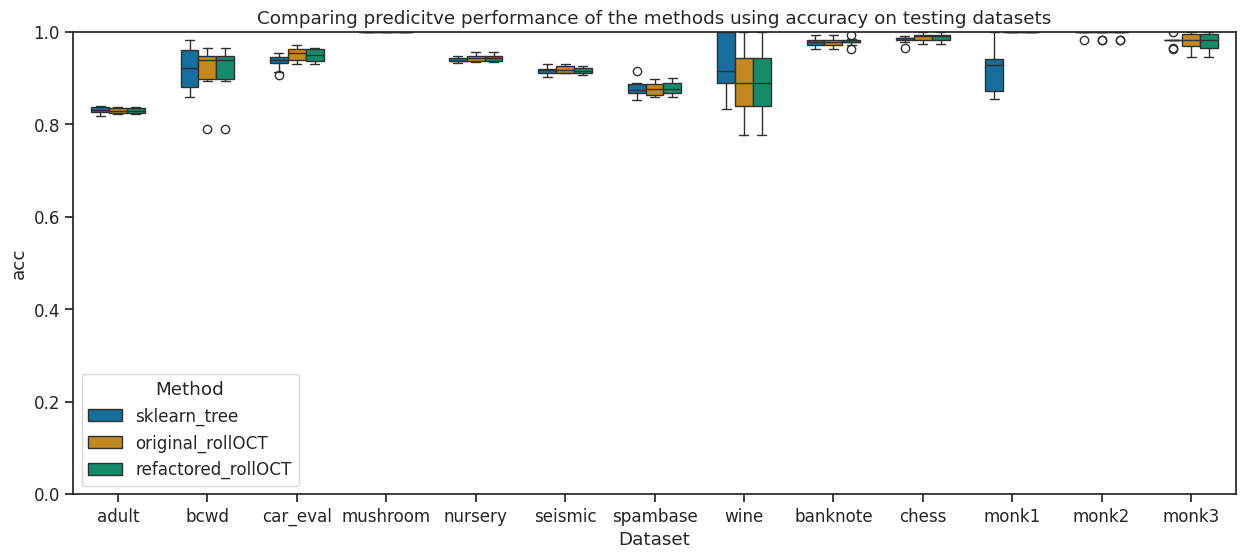

In [10]:
figure_acc_seaborne_all(list_names = list_names, depth=8, alias_dict = alias_dict, folds_tree = 10)